In [1]:
import sys
sys.path.append("..")

## In this notebook:

- **Create df** of:
    - calculated setup using raw data, aligned it to a df: 
        - took 1 min means of h1 and h6
        - demeaned h1 and h6
        - computed using h1 - h6
    - Compute L0 using weighted mean frequency

- ** create binned_df** of:
    - binned data, assuming H0 is the binning catalyst
    - used bin_stats fnction in statistics.py

- line fitting computing reduced chi^2 (chi_sq / dof)
    - weighted linear regression
    - monismith fit (with offset)
    - H0^b fit

- computed setdown in S6 (but incorrectly)



## Statistical Analysis Week

#### Meeting summary notes:

| Topic | MM's Suggestion | Rationale |
| :--- | :--- | :--- |
| **Noise Reduction** | **Bin the x-axis** (e.g., wave height), then compute the **average** and **Standard Error** (or standard deviation) of the Setup ($\eta$) within each bin. | This process, often called **bin-averaging**, reduces scatter (noise) in the data points, making the underlying relationship between the independent variable ($x$) and Setup ($y$) clearer. |
| **Wavelength ($L_0$) Calculation** | Use a **weighted mean** of the frequencies in the **Sea-Swell (SS) band** to determine the characteristic frequency (and thus $L_0$). | The weighting factor should be the Power Spectral Density (PSD) at each frequency. The characteristic frequency, $f_{char}$, is: <br> $f_{char} = \frac{\sum (f \cdot PSD(f))}{\sum PSD(f)}$ <br> This is essentially the **mean frequency** of the wave energy spectrum, providing a more robust $L_0$ than just using the peak period. |
| **Non-Linear Regression** | Explore the relationship $\eta = aH_0^bL_0^c$ using the **Greedy Method** (or log-linear regression) described in a paper by Monismith. | This transformation turns the non-linear power-law equation into a linear equation: <br> $\log_{10}(\eta) = \log_{10}(a) + b \log_{10}(H_0) + c \log_{10}(L_0)$ <br> You can then use **standard multiple linear regression** to find the best-fit coefficients for $\log_{10}(a)$, $b$, and $c$. |

#### Last week's code:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.spectra import sensor_spectra
from src.bulk_parameters import Hs_band, compute_H0

# load data #
df1 = pd.read_parquet('../data_interim/df1.parquet')
df6 = pd.read_parquet('../data_interim/df6.parquet')

# 1. 30 minute spectral averages#
nperseg= 3600 // 2 # 30 min at 1hz intervals

S1 = sensor_spectra(df1, nperseg=nperseg)
S6 = sensor_spectra(df6, nperseg=nperseg)

# 2. backrefract to compute H0
df_waves = compute_H0(S6, fmin=0.04, fmax=0.33)
H0_ser = pd.Series(df_waves['H0'], index=pd.to_datetime(df_waves.index)).sort_index()

# 3. Calculate Setup from RAW data
# Use the original high-freq dataframes where you know timestamps are correct
# We resample to 1-min averages first to reduce noise, then subtract
raw_h1, raw_h6 = df1['h'].resample('1min').mean() , df6['h'].resample('1min').mean()

# Align the raw data
# This handles any start-time differences or missing data automatically
aligned_df = pd.merge_asof(
    raw_h1.sort_index().to_frame('h1'),
    raw_h6.sort_index().to_frame('h6'),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=5)
).dropna()
# compute cross shore setup n 
# n = (Shore - Mean_Shore) - (Offshore - Mean_Offshore)
p1, p6 = aligned_df['h1'] - aligned_df['h1'].mean(), aligned_df['h6'] - aligned_df['h6'].mean()
n_raw = p1 - p6  



In [3]:

# # 4. Map the calculated setup to wave timestamps
H0_df = H0_ser.to_frame(name='H0').sort_index()
n_df = n_raw.to_frame(name='n').sort_index()
# Merge setup onto the wave timestamps
final_df = pd.merge_asof(
    H0_df,
    n_df,
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30) # Grab the setup closest to the spectral burst
).dropna()

# 5. Align tide series to the existing spectral data
# demeaned tide
tide = df6['h_tide'] - df6['h_tide'].mean()
# merge tide onto the aligned df
final_df = pd.merge_asof(
    final_df,                    # The dataframe with H0 and n
    tide,   # The tide data
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30) 
).dropna()

# # check if 'Tp is already in final ddf to avoid 'run twice' errors
# if 'Tp' not in final_df.columns:
#     # extract Tp from S6 spectra
#     if 'Seta' in S6:
#         fp_xarray = S6['Seta'].idxmax(dim='frequency')
#         Tp_ser = (1 / fp_xarray).to_series().rename('Tp')
#         # merge Tp onto final df
#         final_df = pd.merge_asof(
#         final_df,                    # The dataframe with H0 and n
#         Tp_ser.sort_index().to_frame(),   # The tide data
#         left_index=True,
#         right_index=True,
#         direction='nearest',
#         tolerance=pd.Timedelta(minutes=30) )

# # compute L0, dw wavelength
# g = 9.81
# final_df['L0'] = (g * final_df['Tp']**2) / (2 * np.pi)


# extract variables for plotting
H0_plot   = final_df['H0']
n_plot    = final_df['n']
tide_plot = final_df['h_tide']

print(f"Final data points: {len(final_df)}")


Final data points: 3309


In [4]:
final_df

,H0,n,h_tide
time,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961
...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873


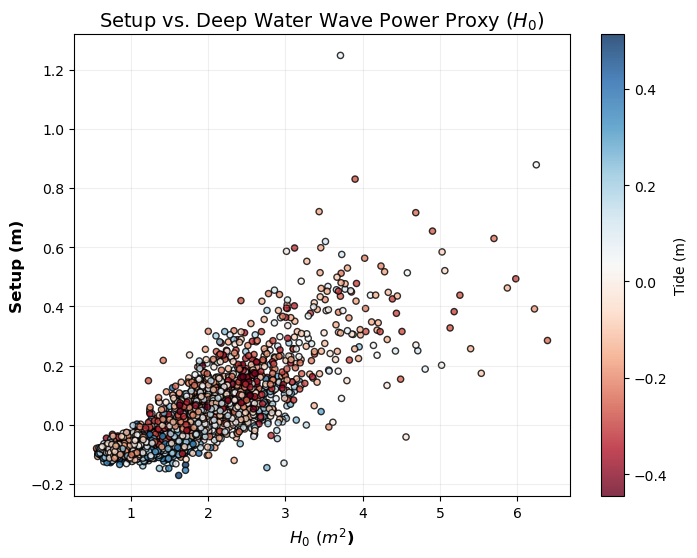

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sc = ax.scatter(final_df['H0'], final_df['n'], 
                c=final_df['h_tide'], cmap="RdBu", edgecolor="k", s=20, alpha=0.8)

ax.set_xlabel(r"$H_0$ $(m^2$)", fontsize=12, fontweight='bold')
ax.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
ax.set_title("Setup vs. Deep Water Wave Power Proxy ($H_0$)", fontsize=14)
ax.grid(True, alpha=0.2)
plt.colorbar(sc, label="Tide (m)")
plt.show()

#### L0 Calculation

Use a weighted mean frequency to compute for L0 

In [6]:
# Define SS Band (example band)
_ss_max = 0.33 # Adjust as per your specific SS band definition
SS = (0.04, 0.33)

# 1. Filter S6 for the SS band
S6_SS = S6.sel(frequency=slice(SS[0], SS[1]))

# 2. Compute the numerator and denominator of f_char
num = (S6_SS['frequency'] * S6_SS['Seta']).sum(dim='frequency')
den = S6_SS['Seta'].sum(dim='frequency')

# 3. Calculate f_char and Tp_char
f_char_ser = (num / den).to_series().rename('f_char')
Tp_char_ser = (1 / f_char_ser).rename('Tp_char') 

# 4. Calculate L0 
g = 9.81
L0 = (g / (2 * np.pi * f_char_ser**2)).rename('L0')

# Merge L0_char_ser into your final_df, similar to how you merged Tp
final_df = pd.merge_asof(
    final_df,
    L0.sort_index().to_frame(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30)
).dropna()

In [7]:
final_df

,H0,n,h_tide,L0
time,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901
...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516


In [8]:
final_df['H0/L0'] = final_df['H0'] / final_df['L0']
final_df

,H0,n,h_tide,L0,H0/L0
time,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951
...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754


<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5825/3201848866.py:13: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel("Setup $\eta$ (m)", fontsize=12, fontweight='bold')


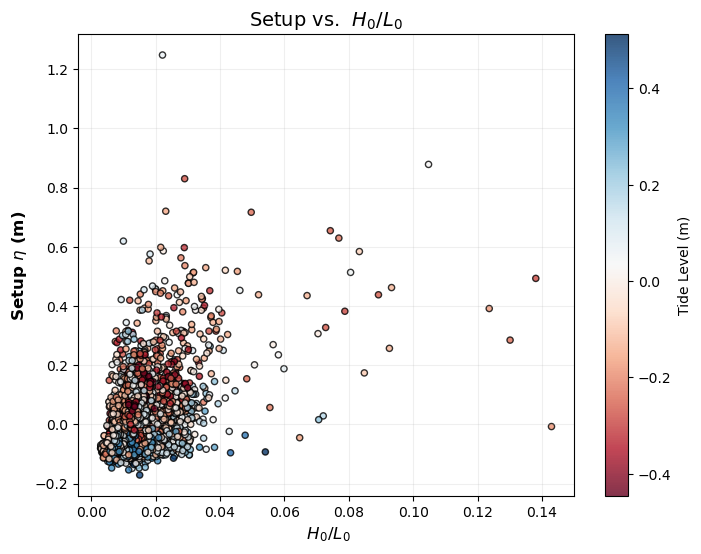

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# 1. Plot the data
sc = ax.scatter(final_df['H0/L0'], final_df['n'], 
                c=final_df['h_tide'], cmap="RdBu", edgecolor="k", s=20, alpha=0.8)



# 3. Fix Labels (You were plotting L0 but labeled it H0)
ax.set_xlabel(r" $H_0/L_0$", fontsize=12, fontweight='bold')
ax.set_ylabel("Setup $\eta$ (m)", fontsize=12, fontweight='bold')
ax.set_title("Setup vs.  $H_0/L_0$", fontsize=14)

ax.grid(True, which='both', alpha=0.2) # 'both' shows minor grid lines for log scale
plt.colorbar(sc, label="Tide Level (m)")

plt.show()

#### Bin Averaging

In [10]:
final_df

,H0,n,h_tide,L0,H0/L0
time,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951
...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754


In [11]:
import pandas as pd
import numpy as np

def bin_stats(df, bin_col, agg_cols, bin_size=None, num_bins=20, min_points=5):
    """
    Bins a DataFrame based on 'bin_col' and computes stats for all columns in 'agg_cols'.
    
    Parameters:
    - bin_col (str): The column to define bin edges (e.g., 'H0').
    - agg_cols (list): List of columns to calculate stats for (e.g. ['H0', 'L0', 'n']).
    - bin_size (float): Size of bins.
    """
    
    # Ensure agg_cols is a list
    if isinstance(agg_cols, str):
        agg_cols = [agg_cols]
        
    # 1. Filter Data: Keep only relevant columns and drop NaNs
    # We allow NaNs in other columns, but rows must be valid for the ones we are calculating
    cols_to_keep = [bin_col] + [c for c in agg_cols if c != bin_col]
    data = df[cols_to_keep].copy().dropna()
    
    # 2. Determine Bin Edges (based on bin_col)
    if bin_size is not None:
        start = np.floor(data[bin_col].min())
        end = np.ceil(data[bin_col].max())
        bins = np.arange(start, end + bin_size, bin_size)
    else:
        bins = np.linspace(data[bin_col].min(), data[bin_col].max(), num_bins + 1)
        
    # 3. Assign Bins
    data['bin_group'] = pd.cut(data[bin_col], bins=bins, include_lowest=True)
    
    # 4. Define Aggregation Dictionary
    # We want mean, std, and count for EVERY column in agg_cols
    agg_dict = {col: ['mean', 'std', 'count'] for col in agg_cols}
    
    # 5. Group and Aggregate
    stats = data.groupby('bin_group', observed=True).agg(agg_dict)
    
    # 6. Flatten MultiIndex Columns
    # Current columns look like: ('H0', 'mean'), ('H0', 'std')...
    # We change them to: 'H0_mean', 'H0_std'...
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
    
    # 7. Calculate SEM (Standard Error) for each variable
    for col in agg_cols:
        # standard error = std / sqrt(count)
        stats[f'{col}_sem'] = stats[f'{col}_std'] / np.sqrt(stats[f'{col}_count'])
        
    # 8. Filter by Minimum Points (using the count of the first column in the list)
    # We assume if H0 has N points, L0 also has N points (since we dropped NaNs)
    ref_count_col = f"{agg_cols[0]}_count"
    stats = stats[stats[ref_count_col] >= min_points].reset_index(drop=True)
    
    return stats

In [12]:
final_df['H0L0'] = final_df['H0'] * final_df['L0']      # Accurate product
final_df['steepness'] = final_df['H0'] / final_df['L0'] # Accurate steepness

binned_df = bin_stats(
    final_df, 
    bin_col='H0', 
    # Add the new columns to this list
    agg_cols=['H0', 'L0', 'n', 'H0L0', 'steepness'], 
    bin_size=0.1
)

binned_df

,H0_mean,H0_std,H0_count,L0_mean,L0_std,L0_count,n_mean,n_std,n_count,H0L0_mean,H0L0_std,H0L0_count,steepness_mean,steepness_std,steepness_count,H0_sem,L0_sem,n_sem,H0L0_sem,steepness_sem
0,0.576098,0.012128,8,119.378614,12.792140,8,-0.090554,0.011189,8,68.725396,6.978675,8,0.004884,0.000630,8,0.004288,4.522704,0.003956,2.467334,0.000223
1,0.658773,0.027603,77,135.119543,35.934925,77,-0.089376,0.013597,77,88.960679,23.875332,77,0.005171,0.001179,77,0.003146,4.095165,0.001550,2.720847,0.000134
2,0.751944,0.028076,117,121.206032,30.783891,117,-0.085279,0.017908,117,91.117089,23.253240,117,0.006512,0.001300,117,0.002596,2.845972,0.001656,2.149763,0.000120
3,0.848764,0.029844,102,104.655226,35.604861,102,-0.081251,0.018028,102,88.442928,29.103472,102,0.008926,0.002671,102,0.002955,3.525407,0.001785,2.881673,0.000264
4,0.952826,0.029349,173,90.151623,22.964306,173,-0.076940,0.019946,173,85.881294,22.168747,173,0.011170,0.002615,173,0.002231,1.745944,0.001516,1.685459,0.000199
5,1.055265,0.028332,225,86.174794,25.463671,225,-0.073213,0.022236,225,90.884935,26.823371,225,0.013161,0.003482,225,0.001889,1.697578,0.001482,1.788225,0.000232
6,1.150438,0.027783,288,88.608661,26.393417,288,-0.066402,0.024042,288,102.009721,30.801103,288,0.014018,0.003862,288,0.001637,1.555247,0.001417,1.814972,0.000228
7,1.249696,0.027884,255,94.323064,29.101052,255,-0.060472,0.032646,255,117.833796,36.401279,255,0.014329,0.003964,255,0.001746,1.822379,0.002044,2.279537,0.000248
8,1.351192,0.029285,251,89.791838,33.547060,251,-0.055082,0.032320,251,121.255913,45.111924,251,0.016576,0.004627,251,0.001848,2.117472,0.002040,2.847439,0.000292
9,1.449792,0.027489,279,91.099016,37.757313,279,-0.048991,0.037412,279,132.166005,55.221058,279,0.017828,0.005141,279,0.001646,2.260471,0.002240,3.305998,0.000308


<>:54: SyntaxWarning: invalid escape sequence '\c'
<>:67: SyntaxWarning: invalid escape sequence '\e'
<>:88: SyntaxWarning: invalid escape sequence '\c'
<>:54: SyntaxWarning: invalid escape sequence '\c'
<>:67: SyntaxWarning: invalid escape sequence '\e'
<>:88: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5825/3716758249.py:54: SyntaxWarning: invalid escape sequence '\c'
  label=f'Fit ($\chi_\\nu^2={red_chi_sq:.1f}$)')
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5825/3716758249.py:67: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel('Setup $\eta$ (m)', fontsize=11)
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5825/3716758249.py:88: SyntaxWarning: invalid escape sequence '\c'
  fig.suptitle('Weighted Linear Fit ($\chi^2$)', fontsize=16)


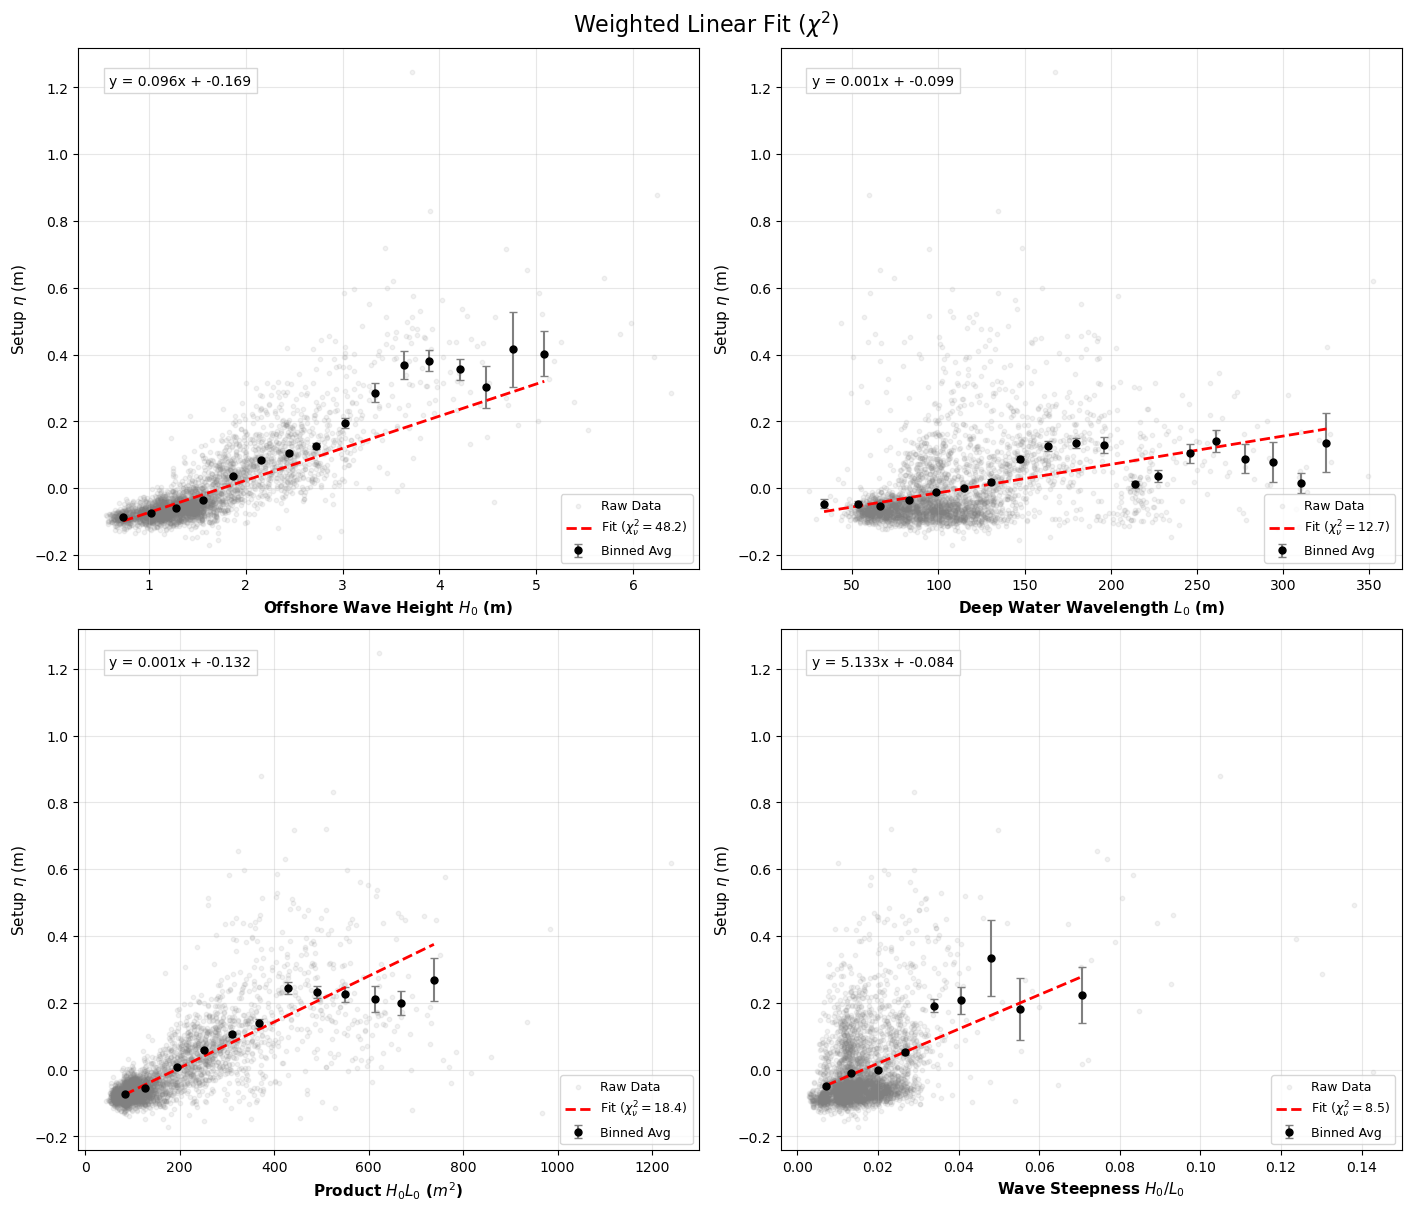

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# 1. Ensure derived columns exist in the RAW dataframe
final_df['H0L0'] = final_df['H0'] * final_df['L0']
final_df['steepness'] = final_df['H0'] / final_df['L0']

# 2. Define the Linear Model
def linear_model(x, m, c):
    return m * x + c

# 3. Define the Plotting Function (Updated for Chi-Squared)
def analyze_and_plot(ax, df, x_col, y_col='n', x_label="", num_bins=20):
    
    # --- A. Bin the Data ---
    # Uses your bin_stats function
    binned = bin_stats(df, bin_col=x_col, agg_cols=[x_col, y_col], num_bins=num_bins)
    
    # Extract vectors using the specific column names from bin_stats
    x_mean = binned[f'{x_col}_mean']
    y_mean = binned[f'{y_col}_mean']
    y_err  = binned[f'{y_col}_sem']
    
    # --- B. Plot Raw Data (Background) ---
    ax.scatter(df[x_col], df[y_col], alpha=0.1, color='gray', s=10, label='Raw Data')
    
    # --- C. Plot Binned Averages ---
    ax.errorbar(x_mean, y_mean, yerr=y_err, fmt='o', color='black', 
                ecolor='gray', capsize=3, markersize=5, label='Binned Avg')

    # --- D. Weighted Linear Fit ---
    try:
        # Fit weighted by 1/SEM
        popt, pcov = curve_fit(linear_model, x_mean, y_mean, sigma=y_err, absolute_sigma=True)
        m, c = popt
        
        # --- CALCULATION CHANGE: Chi-Squared instead of R2 ---
        y_model = linear_model(x_mean, *popt)
        residuals = y_mean - y_model
        
        # Chi-Squared Sum: sum( (observed - model)^2 / error^2 )
        chi_sq = np.sum((residuals / y_err)**2)
        
        # Degrees of Freedom (dof) = Number of Bins - Number of Parameters (2)
        dof = len(x_mean) - 2
        
        # Reduced Chi-Squared
        red_chi_sq = chi_sq / dof
        
        # Plot the Fit Line
        x_range = np.linspace(x_mean.min(), x_mean.max(), 100)
        ax.plot(x_range, linear_model(x_range, m, c), 'r--', linewidth=2, 
                label=f'Fit ($\chi_\\nu^2={red_chi_sq:.1f}$)')
        
        # Add Equation Text
        eq_text = f"y = {m:.3f}x + {c:.3f}"
        ax.text(0.05, 0.95, eq_text, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top', 
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgray'))
        
    except Exception as e:
        print(f"Fit failed for {x_col}: {e}")

    # --- E. Formatting ---
    ax.set_xlabel(x_label, fontsize=11, fontweight='bold')
    ax.set_ylabel('Setup $\eta$ (m)', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='lower right')

# --- Main Plotting Routine ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)
axes = axes.flatten()

# 1. Setup vs H0
analyze_and_plot(axes[0], final_df, 'H0', x_label='Offshore Wave Height $H_0$ (m)')

# 2. Setup vs L0
analyze_and_plot(axes[1], final_df, 'L0', x_label='Deep Water Wavelength $L_0$ (m)')

# 3. Setup vs H0 * L0
analyze_and_plot(axes[2], final_df, 'H0L0', x_label='Product $H_0 L_0$ ($m^2$)')

# 4. Setup vs Steepness (H0 / L0)
analyze_and_plot(axes[3], final_df, 'steepness', x_label='Wave Steepness $H_0 / L_0$')

# Title
fig.suptitle('Weighted Linear Fit ($\chi^2$)', fontsize=16)

plt.show()

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5825/4073246058.py:18: SyntaxWarning: invalid escape sequence '\p'
  label='Binned Avg $\pm$ SEM'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5825/4073246058.py:22: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Setup $\eta$ (m)')


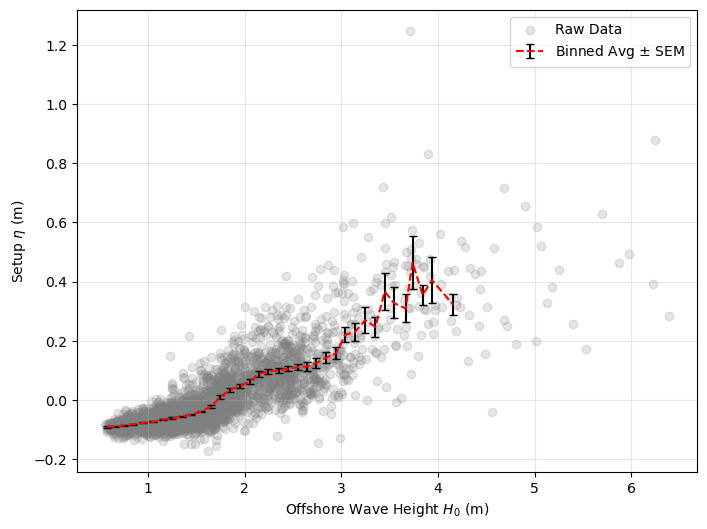

In [14]:
# plotting code
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# original raw data 
plt.scatter(final_df['H0'], final_df['n'], alpha=0.2, c='gray', label='Raw Data')

# binned averages with Error Bars
plt.errorbar(
    binned_df['H0_mean'], 
    binned_df['n_mean'], 
    yerr=binned_df['n_sem'], 
    fmt='--', 
    color='red', 
    ecolor='black', 
    capsize=3, 
    label='Binned Avg $\pm$ SEM'
)

plt.xlabel('Offshore Wave Height $H_0$ (m)')
plt.ylabel('Setup $\eta$ (m)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### nonlinear curve fitting

<>:85: SyntaxWarning: invalid escape sequence '\e'
<>:86: SyntaxWarning: invalid escape sequence '\c'
<>:85: SyntaxWarning: invalid escape sequence '\e'
<>:86: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5825/553416016.py:85: SyntaxWarning: invalid escape sequence '\e'
  title_str = (f"Monismith Fit: $\eta = {a:.3f} H_0^{{{b:.2f}}} L_0^{{{c:.2f}}}$\n"
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5825/553416016.py:86: SyntaxWarning: invalid escape sequence '\c'
  f"RMSE = {rmse:.3f} m | $\chi_\\nu^2$ = {red_chi_sq:.2f}")


Fit Successful: a=0.0000, b=5.000, c=0.817
Reduced Chi-Squared: 568.21


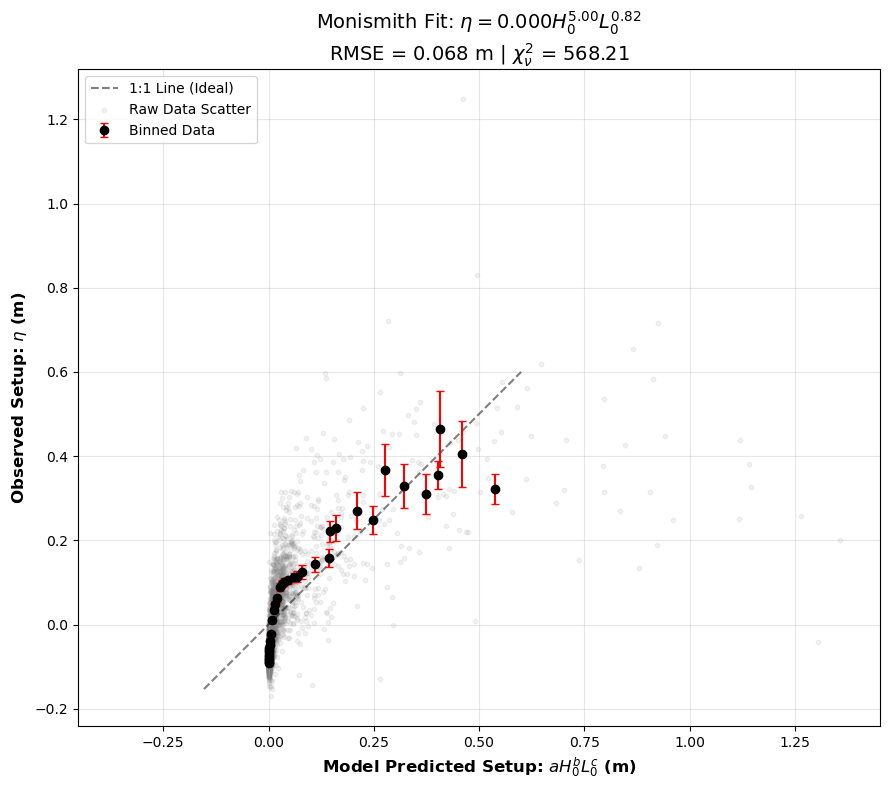

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# --- 1. PREPARE DATA ---
# (Assuming 'binned_df' and 'final_df' are already loaded from your previous steps)

# Extract Binned Data (The physics we trust)
sigma_n = binned_df['n_sem']
y_binned = binned_df['n_mean']
x_binned = np.vstack((binned_df['H0_mean'], binned_df['L0_mean']))

# Extract Raw Data (The background scatter)
raw_clean = final_df[['H0', 'L0', 'n']].dropna()
x_raw = np.vstack((raw_clean['H0'], raw_clean['L0']))
y_raw = raw_clean['n']

# --- 2. DEFINE MODEL ---
def monismith(X, a, b, c):
    H0, L0 = X
    return a * (H0**b) * (L0**c)

# --- 3. FIT WITH BOUNDS (The Fix) ---
# We force 'a' to be positive (0 to infinity) so setup doesn't flip negative
# We allow 'b' and 'c' to range from -5 to 5 (covering most power laws)
lower_bounds = [0.00001, -5.0, -5.0]
upper_bounds = [np.inf,   5.0,  5.0]

# Initial guess: Start with something physically reasonable
# a=0.1, b=1.0 (linear H0), c=0.0 (no L0 dependence yet)
p0 = [0.1, 1.0, 0.0]

try:
    popt, pcov = curve_fit(
        monismith, 
        x_binned, 
        y_binned, 
        sigma=sigma_n, 
        absolute_sigma=True, 
        p0=p0,
        bounds=(lower_bounds, upper_bounds) # <--- This prevents the weird shape!
    )
    
    a, b, c = popt
    perr = np.sqrt(np.diag(pcov))
    
    # --- 4. CALCULATE METRICS ---
    y_pred_bin = monismith(x_binned, *popt)
    y_pred_raw = monismith(x_raw, *popt)
    
    # Reduced Chi-Squared
    residuals = y_binned - y_pred_bin
    chi_sq = np.sum((residuals / sigma_n)**2)
    dof = len(y_binned) - 3
    red_chi_sq = chi_sq / dof
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_binned, y_pred_bin))

    print(f"Fit Successful: a={a:.4f}, b={b:.3f}, c={c:.3f}")
    print(f"Reduced Chi-Squared: {red_chi_sq:.2f}")

    # --- 5. PLOT ---
    plt.figure(figsize=(9, 8))
    
    # A. 1:1 Line
    dmin = min(y_binned.min(), y_pred_bin.min())
    dmax = max(y_binned.max(), y_pred_bin.max())
    pad = (dmax - dmin) * 0.1
    plt.plot([dmin-pad, dmax+pad], [dmin-pad, dmax+pad], 'k--', alpha=0.5, label='1:1 Line (Ideal)')
    
    # B. Raw Scatter (Gray)
    plt.scatter(y_pred_raw, y_raw, color='gray', s=10, alpha=0.1, label='Raw Data Scatter')
    
    # C. Binned Averages (Black with Error Bars)
    plt.errorbar(y_pred_bin, y_binned, yerr=sigma_n, 
                 fmt='o', color='black', ecolor='red', capsize=3, markersize=6,
                 label=f'Binned Data')

    # Formatting
    plt.xlabel(r'Model Predicted Setup: $a H_0^b L_0^c$ (m)', fontsize=12, fontweight='bold')
    plt.ylabel(r'Observed Setup: $\eta$ (m)', fontsize=12, fontweight='bold')
    
    title_str = (f"Monismith Fit: $\eta = {a:.3f} H_0^{{{b:.2f}}} L_0^{{{c:.2f}}}$\n"
                 f"RMSE = {rmse:.3f} m | $\chi_\\nu^2$ = {red_chi_sq:.2f}")
    plt.title(title_str, fontsize=14)
    
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.axis('equal') 
    plt.xlim(0,1.0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Fit Failed: {e}")

Fit Successful: a=0.0010, b=1.741, c=0.772, d=-0.110


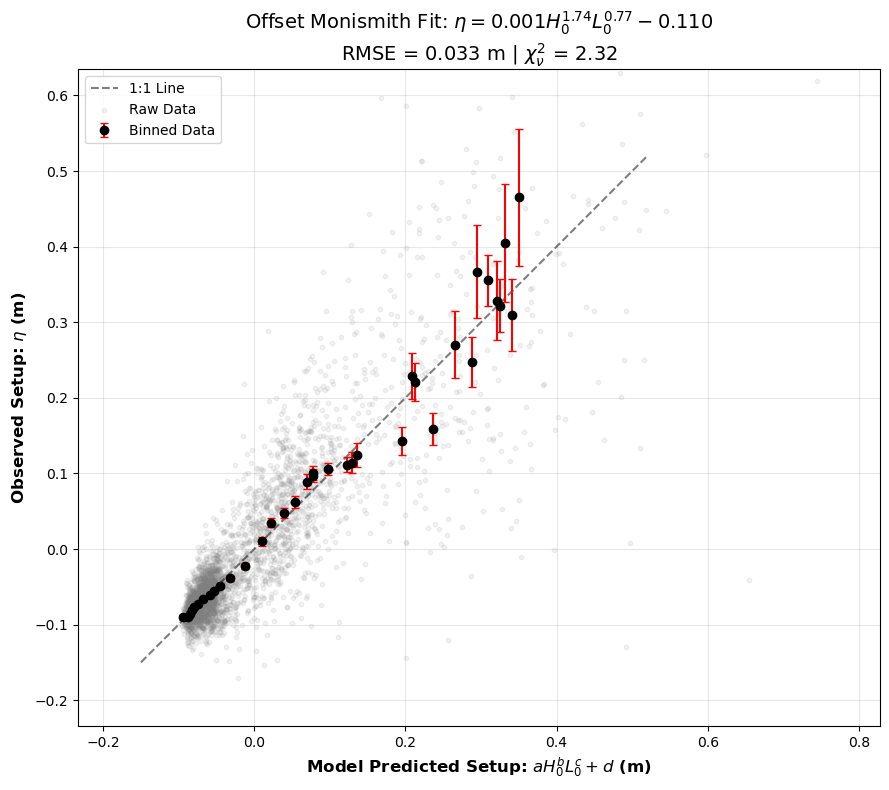

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# --- 1. PREPARE DATA ---
# (Assuming binned_df is already created via bin_stats)
sigma_n = binned_df['n_sem']
y_binned = binned_df['n_mean']
x_binned = np.vstack((binned_df['H0_mean'], binned_df['L0_mean']))

# Raw data for plotting background
raw_clean = final_df[['H0', 'L0', 'n']].dropna()
x_raw = np.vstack((raw_clean['H0'], raw_clean['L0']))
y_raw = raw_clean['n']

# --- 2. DEFINE MODEL WITH OFFSET ---
def monismith_offset(X, a, b, c, d):
    H0, L0 = X
    return a * (H0**b) * (L0**c) + d  # <--- Added 'd'

# --- 3. FIT WITH BOUNDS ---
# Bounds: 
# a: positive (0 to inf)
# b, c: power laws (-5 to 5)
# d: offset (can be negative! -0.5m to 0.5m)
lower_bounds = [0.00001, -5.0, -5.0, -0.5]
upper_bounds = [np.inf,   5.0,  5.0,  0.5]

# Initial Guess (p0):
# a=0.1, b=2 (quadratic-ish), c=0, d=-0.15 (guess based on your plots)
p0 = [0.1, -2.0, 0.0, -0.15]

try:
    popt, pcov = curve_fit(
        monismith_offset, 
        x_binned, 
        y_binned, 
        sigma=sigma_n, 
        absolute_sigma=True, 
        p0=p0,
        bounds=(lower_bounds, upper_bounds)
    )
    
    a, b, c, d = popt
    
    # --- 4. CALCULATE METRICS ---
    y_pred_bin = monismith_offset(x_binned, *popt)
    y_pred_raw = monismith_offset(x_raw, *popt)
    
    residuals = y_binned - y_pred_bin
    # Reduced Chi Squared (4 parameters now)
    red_chi_sq = np.sum((residuals / sigma_n)**2) / (len(y_binned) - 4)
    rmse = np.sqrt(mean_squared_error(y_binned, y_pred_bin))

    print(f"Fit Successful: a={a:.4f}, b={b:.3f}, c={c:.3f}, d={d:.3f}")
    
    # --- 5. PLOT ---
    plt.figure(figsize=(9, 8))
    
    # 1:1 Line
    dmin = min(y_binned.min(), y_pred_bin.min())
    dmax = max(y_binned.max(), y_pred_bin.max())
    pad = (dmax - dmin) * 0.1
    plt.plot([dmin-pad, dmax+pad], [dmin-pad, dmax+pad], 'k--', alpha=0.5, label='1:1 Line')
    
    # Data
    plt.scatter(y_pred_raw, y_raw, color='gray', s=10, alpha=0.1, label='Raw Data')
    plt.errorbar(y_pred_bin, y_binned, yerr=sigma_n, 
                 fmt='o', color='black', ecolor='red', capsize=3, markersize=6,
                 label='Binned Data')

    # Formatting with RAW STRING (rf"")
    plt.xlabel(rf'Model Predicted Setup: $a H_0^b L_0^c + d$ (m)', fontsize=12, fontweight='bold')
    plt.ylabel(rf'Observed Setup: $\eta$ (m)', fontsize=12, fontweight='bold')
    
    title_str = (rf"Offset Monismith Fit: $\eta = {a:.3f} H_0^{{{b:.2f}}} L_0^{{{c:.2f}}} {d:+.3f}$" + "\n" +
                 rf"RMSE = {rmse:.3f} m | $\chi_\nu^2$ = {red_chi_sq:.2f}")
    plt.title(title_str, fontsize=14)
    
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.axis('equal') 
    plt.ylim(-0.2, 0.6)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Fit Failed: {e}")

In [17]:
np.sqrt(0.001)

0.03162277660168379

#### non dimensional, non-linear curve fitting

#### setdown 

ok its time to incorporate setdown into the setup equation as shown by Becker (2014) where $$\eta = h_{near} - h_{far} + \eta_{setdown}$$

In [18]:
import xarray as xr
import pandas as pd
import numpy as np

# --- 1. Align Depth (df6) to Spectra (S6) ---
# Assuming S6 is your xarray Dataset and has a coordinate 'time'
# Assuming df6 is your pandas DataFrame with a datetime index

# Convert pandas depth to xarray for easy interpolation
depth_da = xr.DataArray(
    df6['h'], 
    coords={'time': df6.index}, 
    dims='time'
)

# Interpolate depth onto S6's time grid
# 'nearest' is okay for slow tides, 'linear' is better if timestamps are far apart
s6_depth = depth_da.interp(time=S6.time, method='linear')

# --- 2. Calculate Spectral Statistics (H and T) ---
# Assuming S6 has a data variable 'energy' (m^2/Hz) and coordinate 'frequency' (Hz)
# If your variable is named differently (e.g., 'density'), swap 'energy' for that name.

# Moment 0: Integral of Energy (Variance)
m0 = S6['Seta'].integrate(coord='frequency')

# Moment 2: Integral of Energy * f^2
m2 = (S6['Seta'] * S6['frequency']**2).integrate(coord='frequency')

# Significant Wave Height (Hs6)
Hs6 = 4 * np.sqrt(m0)

# Zero-crossing Period (Tm02) - often better for setdown than Tp
Tm02 = np.sqrt(m0 / m2)

# --- 3. Vectorized Dispersion & Setdown ---
# We need a vectorized solver because apply() is too slow for xarrays
def get_k_vectorized(T, h, g=9.81):
    """
    Vectorized Newton-Raphson solver for dispersion relation.
    sigma^2 = g * k * tanh(kh)
    """
    sigma = 2 * np.pi / T
    k = sigma**2 / g  # Deep water guess
    
    # 3 iterations is usually sufficient for high precision
    for i in range(3):
        kh = k * h
        tanh_kh = np.tanh(kh)
        f = (g * k * tanh_kh) - sigma**2
        df = g * (tanh_kh + kh * (1 - tanh_kh**2))
        k = k - f / df
    return k

# Calculate k (Wave Number)
# We use .values to work with numpy arrays for speed, then wrap back to xarray if needed
k_values = get_k_vectorized(Tm02.values, s6_depth.values)

# Put k back into an xarray structure (optional, but good for plotting later)
k_da = xr.DataArray(k_values, coords=Tm02.coords, name='wavenumber')

# --- 4. Calculate Setdown ---
# Formula: -1/8 * H^2 * k / sinh(2kh)
# Note: We use Hm0 for H here.
numerator = Hs6**2 * k_da
denominator = np.sinh(2 * k_da * s6_depth)

setdown = -0.125 * (numerator / denominator)

# Add to your dataset so everything is in one place
S6['setdown'] = setdown
S6['depth_interp'] = s6_depth
S6['Hs6'] = Hs6
S6['Tm02'] = Tm02

print("Calculation complete. Setdown stored in S6['setdown']")

Calculation complete. Setdown stored in S6['setdown']


Fit Successful: a=0.0294, b=2.124, c=-0.104


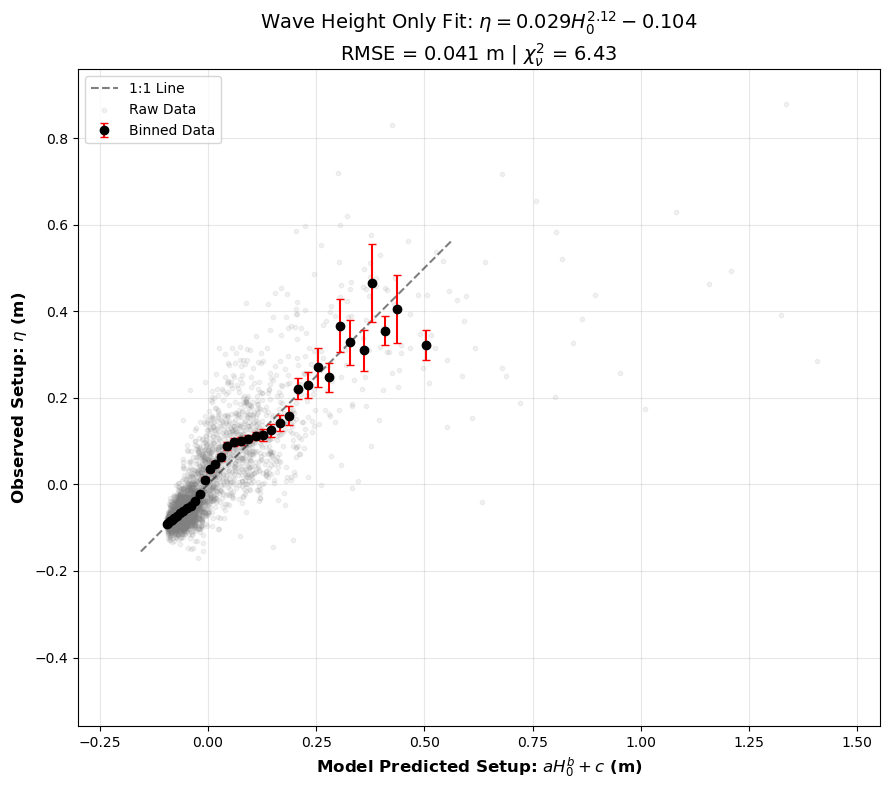

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# --- 1. PREPARE DATA ---
# (Assuming binned_df is already created via bin_stats)
sigma_n = binned_df['n_sem']
y_binned = binned_df['n_mean']
# We still stack them to keep the format consistent, 
# but the function will only use the first row.
x_binned = np.vstack((binned_df['H0_mean'], binned_df['L0_mean']))

# Raw data
raw_clean = final_df[['H0', 'L0', 'n']].dropna()
x_raw = np.vstack((raw_clean['H0'], raw_clean['L0']))
y_raw = raw_clean['n']

# --- 2. DEFINE MODEL (Wave Height Only) ---
def wave_only(X, a, b, c):
    # FIX 1: Unpack only the first row (H0)
    H0 = X[0] 
    return a * (H0**b) + c  

# --- 3. FIT WITH BOUNDS ---
# Bounds for 3 parameters: [a, b, c]
lower_bounds = [0.00001, -5.0, -0.5]
upper_bounds = [np.inf,   5.0,  0.5]

# Initial Guess: [a, b, c]
p0 = [0.1, 2.0, -0.15]

try:
    popt, pcov = curve_fit(
        wave_only, 
        x_binned, 
        y_binned, 
        sigma=sigma_n, 
        absolute_sigma=True, 
        p0=p0,
        bounds=(lower_bounds, upper_bounds)
    )
    
    a, b, c = popt
    
    # --- 4. CALCULATE METRICS ---
    y_pred_bin = wave_only(x_binned, *popt)
    y_pred_raw = wave_only(x_raw, *popt)
    
    residuals = y_binned - y_pred_bin
    
    # FIX 2: Degrees of freedom is N - 3 (since we have params a, b, c)
    red_chi_sq = np.sum((residuals / sigma_n)**2) / (len(y_binned) - 3)
    rmse = np.sqrt(mean_squared_error(y_binned, y_pred_bin))

    print(f"Fit Successful: a={a:.4f}, b={b:.3f}, c={c:.3f}")
    
    # --- 5. PLOT ---
    plt.figure(figsize=(9, 8))
    
    # 1:1 Line
    dmin = min(y_binned.min(), y_pred_bin.min())
    dmax = max(y_binned.max(), y_pred_bin.max())
    pad = (dmax - dmin) * 0.1
    plt.plot([dmin-pad, dmax+pad], [dmin-pad, dmax+pad], 'k--', alpha=0.5, label='1:1 Line')
    
    # Data
    plt.scatter(y_pred_raw, y_raw, color='gray', s=10, alpha=0.1, label='Raw Data')
    plt.errorbar(y_pred_bin, y_binned, yerr=sigma_n, 
                 fmt='o', color='black', ecolor='red', capsize=3, markersize=6,
                 label='Binned Data')

    # Formatting (FIX 3: Removed L0 and d from strings)
    plt.xlabel(rf'Model Predicted Setup: $a H_0^b + c$ (m)', fontsize=12, fontweight='bold')
    plt.ylabel(rf'Observed Setup: $\eta$ (m)', fontsize=12, fontweight='bold')
    
    title_str = (rf"Wave Height Only Fit: $\eta = {a:.3f} H_0^{{{b:.2f}}} {c:+.3f}$" + "\n" +
                 rf"RMSE = {rmse:.3f} m | $\chi_\nu^2$ = {red_chi_sq:.2f}")
    plt.title(title_str, fontsize=14)
    
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.axis('equal') 
    plt.ylim(-0.2, 0.6)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Fit Failed: {e}")

In [20]:
1/10**-2.9

794.3282347242813

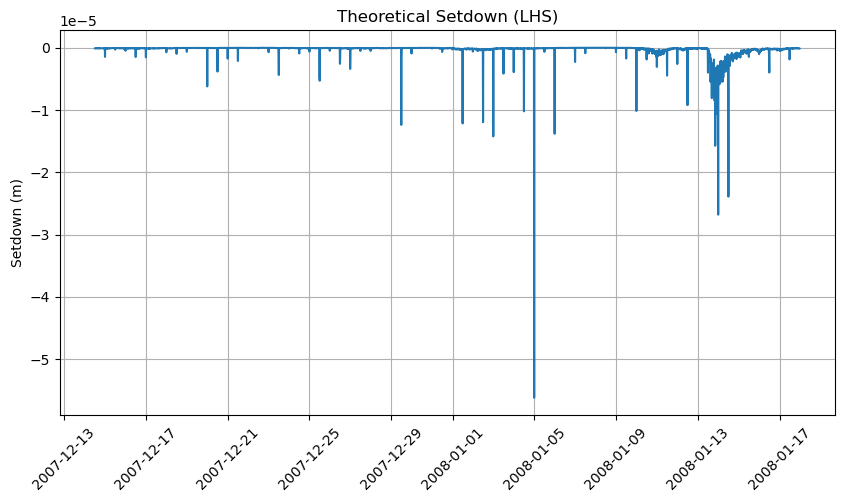

In [21]:
import matplotlib.pyplot as plt

# Assuming your time coordinate is named 'time'
plt.figure(figsize=(10,5))
plt.plot(setdown.time, setdown)
plt.ylabel('Setdown (m)')
plt.title('Theoretical Setdown (LHS)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show() # or plt.draw()

In [36]:
S6['setdown'].max()

<xarray.DataArray 'setdown' ()> Size: 8B
array(-1.0469004e-09)

In [23]:
# check if 'Tp' is already in final_df to avoid 'run twice' errors
if 'Tp' not in final_df.columns:
    # extract Tp from S6 spectra
    if 'Seta' in S6:
        # Define cutoff frequency: T >= 4s corresponds to f <= 0.25 Hz
        f_max = 1 / 4.0
        
        # 1. Select only the part of the spectrum with periods >= 4s (freq <= 0.25)
        # Assuming your frequency coord is sorted ascending (0 -> Nyquist)
        Seta_filtered = S6['Seta'].sel(frequency=slice(None, f_max))
        
        # 2. Find the freq of the max energy in this filtered band
        fp_xarray = Seta_filtered.idxmax(dim='frequency')
        
        # 3. Convert to period
        Tp_ser = (1 / fp_xarray).to_series().rename('Tp')

        # merge Tp onto final df
        final_df = pd.merge_asof(
            final_df,                       # The dataframe with H0 and n
            Tp_ser.sort_index().to_frame(), # The tide/wave data
            left_index=True,
            right_index=True,
            direction='nearest',
            tolerance=pd.Timedelta(minutes=30)
        )

In [24]:
final_df

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp
time,,,,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955,150.728218,0.017955,14.634210
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696,134.353266,0.019696,13.846214
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448,144.989335,0.018448,14.173290
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691,116.178469,0.019691,13.333391
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951,95.942475,0.019951,13.740518
...,...,...,...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608,230.658171,0.011608,12.676112
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486,250.038532,0.013486,13.333391
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754,210.542782,0.012754,12.949697


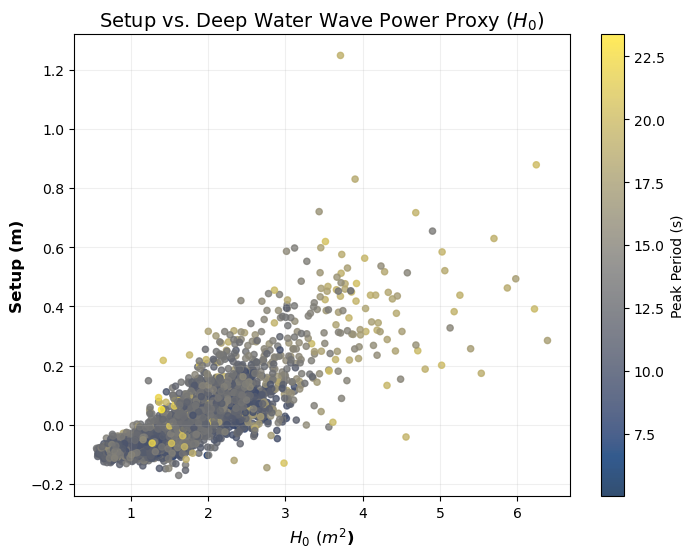

In [25]:
H0_plot   = final_df['H0']
n_plot    = final_df['n']
Tp_plot = final_df['Tp']

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sc = ax.scatter(final_df['H0'], final_df['n'], 
                c=final_df['Tp'], cmap="cividis", s=20, alpha=0.8)

ax.set_xlabel(r"$H_0$ $(m^2$)", fontsize=12, fontweight='bold')
ax.set_ylabel("Setup (m)", fontsize=12, fontweight='bold')
ax.set_title("Setup vs. Deep Water Wave Power Proxy ($H_0$)", fontsize=14)
ax.grid(True, alpha=0.2)
plt.colorbar(sc, label="Peak Period (s)")
plt.show()

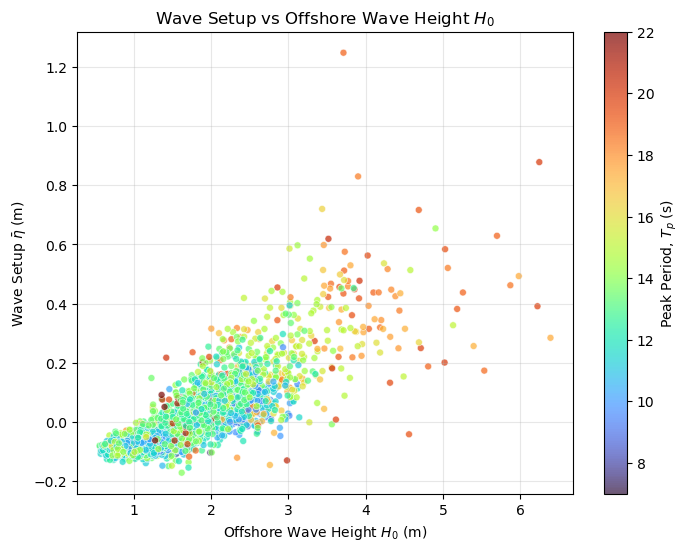

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Scatter plot: Setup vs H0, colored by Tp
sc = plt.scatter(
    final_df['H0'], 
    final_df['n'], 
    c=final_df['Tp'], 
    cmap='turbo',  # <--- The choice
    s=25,           # point size
    alpha=0.7,      # slight transparency helps if points overlap
    edgecolors='w', # white edge makes dots distinct
    vmin = 7,
    vmax = 22.,
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label(r'Peak Period, $T_p$ (s)')

plt.xlabel('Offshore Wave Height $H_0$ (m)')
plt.ylabel(r'Wave Setup $\bar{\eta}$ (m)')
plt.grid(True, alpha=0.3)
plt.title(r'Wave Setup vs Offshore Wave Height $H_0$')

plt.show()

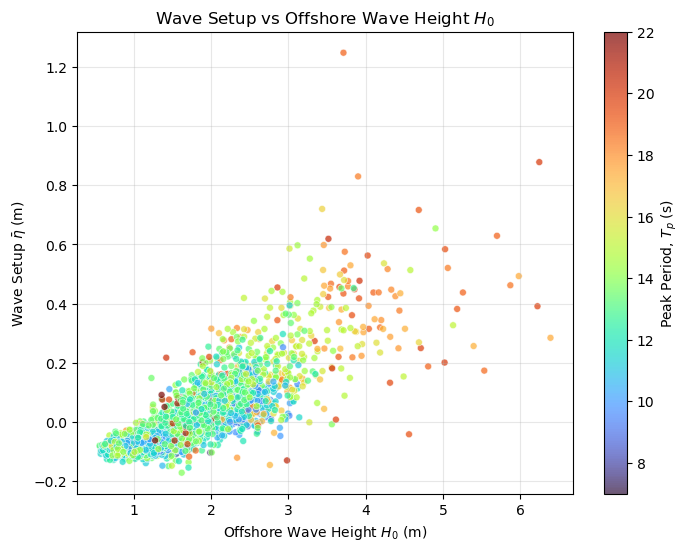

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Scatter plot: Setup vs H0, colored by Tp
sc = plt.scatter(
    final_df['H0'], 
    final_df['n'], 
    c=final_df['Tp'], 
    cmap='turbo',  # <--- The choice
    s=25,           # point size
    alpha=0.7,      # slight transparency helps if points overlap
    edgecolors='w', # white edge makes dots distinct
    vmin = 7,
    vmax = 22.,
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label(r'Peak Period, $T_p$ (s)')

plt.xlabel('Offshore Wave Height $H_0$ (m)')
plt.ylabel(r'Wave Setup $\bar{\eta}$ (m)')
plt.grid(True, alpha=0.3)
plt.title(r'Wave Setup vs Offshore Wave Height $H_0$')

plt.show()

In [28]:
final_df['Tp'].max()

23.376725111688312

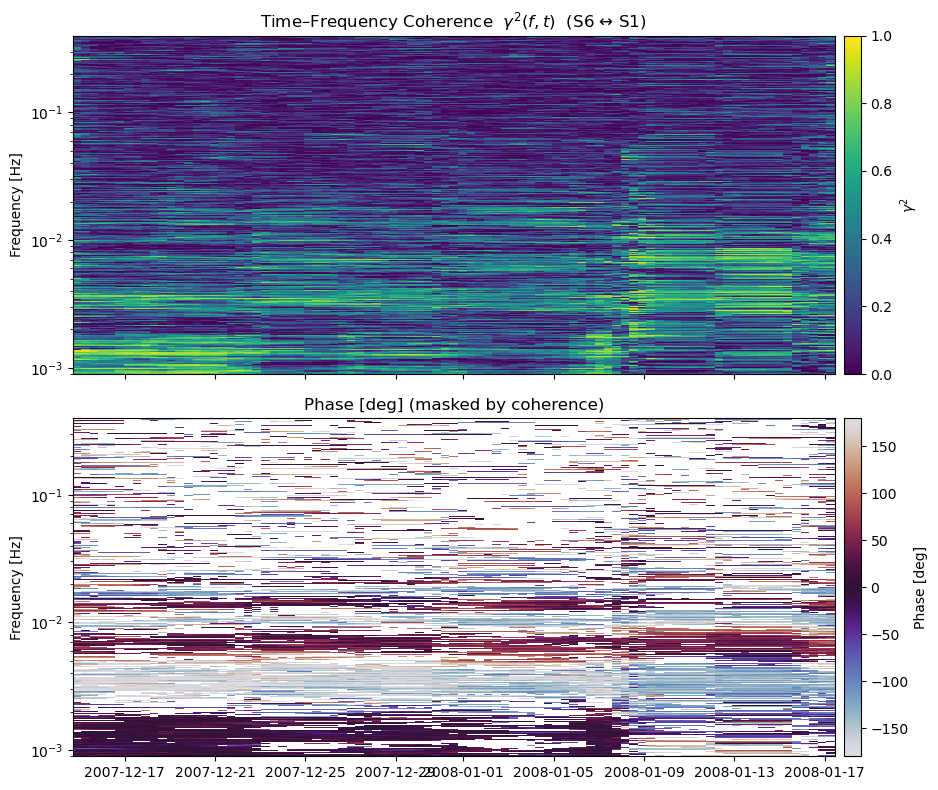

In [29]:
from scipy.signal import spectrogram, convolve


## ------- Coherence thru time series --------- ##


# ------------------- params -------------------
# STFT parameters (same style you've been using)
nperseg = 65536
noverlap = nperseg // 2
window   = 'hann'
detrend  = 'linear'
scaling  = 'density'
# display band
fmin, fmax = 0.0009, 0.40          # show IG up through swell
# time-smoothing across adjacent STFT windows (improves DoF for γ²)
tsmooth = 9                        # odd integer (e.g., 5, 9, 13)
coh_mask = 0.2                     # hide phase where coherence < this

# ------------------- align data -------------------
x = df6['p'].dropna()              # offshore
y = df1['p'].dropna()              # nearshore
x, y = x.align(y, join='inner')
fs = 1.0 / (np.median(np.diff(x.index.view('int64'))) / 1e9)

# ------------------- complex spectrograms -------------------
# mode='complex' gives STFT coefficients X(f,t), Y(f,t)
f, tsec, X = spectrogram(
    x.values, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
    detrend=detrend, scaling=scaling, mode='complex'
)
_, _, Y = spectrogram(
    y.values, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
    detrend=detrend, scaling=scaling, mode='complex'
)

# convert spectrogram time centers to datetimes
t0 = x.index[0]
t = pd.to_datetime(t0) + pd.to_timedelta(tsec, unit='s')

# band-limit
band = (f >= fmin) & (f <= fmax)
f = f[band]
X = X[band, :]
Y = Y[band, :]

# ------------------- cross-spectral quantities (time-resolved) -------------------
Sxx = np.abs(X)**2
Syy = np.abs(Y)**2
Sxy = X * np.conj(Y)               # complex cross-spectrum

# smooth along time to stabilize estimates (<> operator over t)
ker = np.ones((1, tsmooth), dtype=float) / tsmooth
Sxx_s = convolve(Sxx, ker, mode='same')
Syy_s = convolve(Syy, ker, mode='same')
Sxy_s = convolve(Sxy, ker, mode='same')

# coherence and phase as functions of (f, t)
coh_ft = (np.abs(Sxy_s)**2) / (Sxx_s * Syy_s)   # ∈ [0,1]
phase_ft = np.angle(Sxy_s)                      # radians

# mask phase where coherence is weak
phase_masked = np.where(coh_ft >= coh_mask, np.degrees(phase_ft), np.nan)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 8), sharex=True,
    gridspec_kw={"height_ratios": [2, 2]}  # make tide shorter
)

# ---- top: coherence ----
im1 = ax1.pcolormesh(t, f, coh_ft, shading="auto", vmin=0, vmax=1, cmap="viridis")
ax1.set_yscale("log")
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title(r"Time–Frequency Coherence  $\gamma^2(f,t)$  (S6 ↔ S1)")
fig.colorbar(im1, ax=ax1, label=r"$\gamma^2$", pad=0.01)

# ---- middle: phase ----
im2 = ax2.pcolormesh(t, f, phase_masked, shading="auto", vmin=-180, vmax=180, cmap="twilight")
ax2.set_yscale("log")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_title("Phase [deg] (masked by coherence)")
fig.colorbar(im2, ax=ax2, label="Phase [deg]", pad=0.01)

plt.tight_layout()
plt.show()



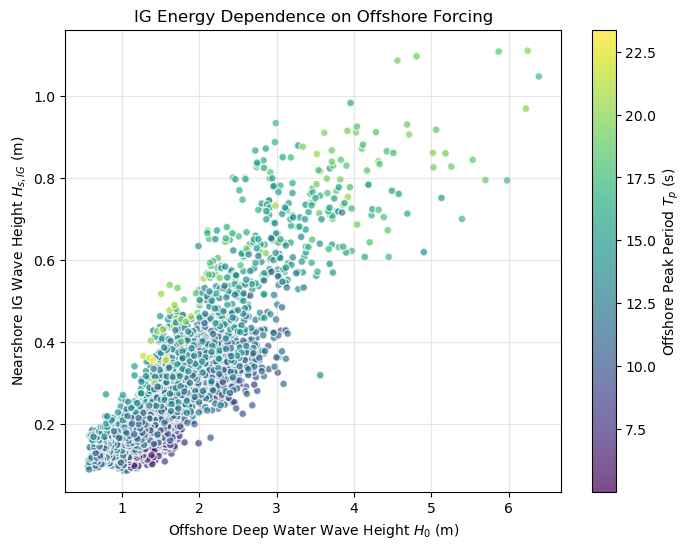

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# 1. Define your IG Frequency Limits (Hz)
f_min_IG = 0.004
f_max_IG = 0.04

# 2. Select the IG band from your S1 xarray Dataset
# Assuming your xarray ds is named 'ds_s1' and the variable is 'Seta'
S1_IG_spectrum = S1['Seta'].sel(frequency=slice(f_min_IG, f_max_IG))

# 3. Integrate to get Variance (m0)
# .integrate() automatically handles the 'df' (frequency spacing)
m0_IG = S1_IG_spectrum.integrate(coord='frequency')

# 4. Calculate Significant Wave Height (Hs)
# Hs = 4 * sqrt(variance)
S1['Hs_IG'] = 4 * np.sqrt(m0_IG)

# ---------------------------------------------------------
# 5. Align and Plot vs Offshore H0
# ---------------------------------------------------------

# Convert the xarray DataArray to a Pandas Series to match your DataFrame
hs_ig_series = S1['Hs_IG'].to_series()

# Merge with your final_df to ensure timestamps align perfectly
# (This handles any gaps or mismatching times automatically)
merged_df = final_df.join(hs_ig_series.rename('Hs_IG_Nearshore'), how='inner')

# 6. Create the "Story" Plot
plt.figure(figsize=(8, 6))

# Scatter plot: Setup vs H0, colored by Peak Period (Tp)
# (Assuming final_df has 'Tp' - if not, add it!)
sc = plt.scatter(merged_df['H0'], 
                 merged_df['Hs_IG_Nearshore'], 
                 c=merged_df['Tp'], 
                 cmap='viridis', 
                 alpha=0.7, 
                 s=30,
                 edgecolors='w')

plt.colorbar(sc, label='Offshore Peak Period $T_p$ (s)')
plt.xlabel('Offshore Deep Water Wave Height $H_0$ (m)')
plt.ylabel('Nearshore IG Wave Height $H_{s,IG}$ (m)')
plt.title('IG Energy Dependence on Offshore Forcing')
plt.grid(True, alpha=0.3)

# Add a 1:1 line for reference (optional, though IG is usually much smaller than H0)
# plt.plot([0, 3], [0, 3], 'k--', alpha=0.5) 

plt.show()

In [31]:
merged_df

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp,Hs_IG_Nearshore
time,,,,,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955,150.728218,0.017955,14.634210,0.196278
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696,134.353266,0.019696,13.846214,0.209341
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448,144.989335,0.018448,14.173290,0.210029
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691,116.178469,0.019691,13.333391,0.205247
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951,95.942475,0.019951,13.740518,0.168462
...,...,...,...,...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608,230.658171,0.011608,12.676112,0.256726
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486,250.038532,0.013486,13.333391,0.227943
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754,210.542782,0.012754,12.949697,0.248969


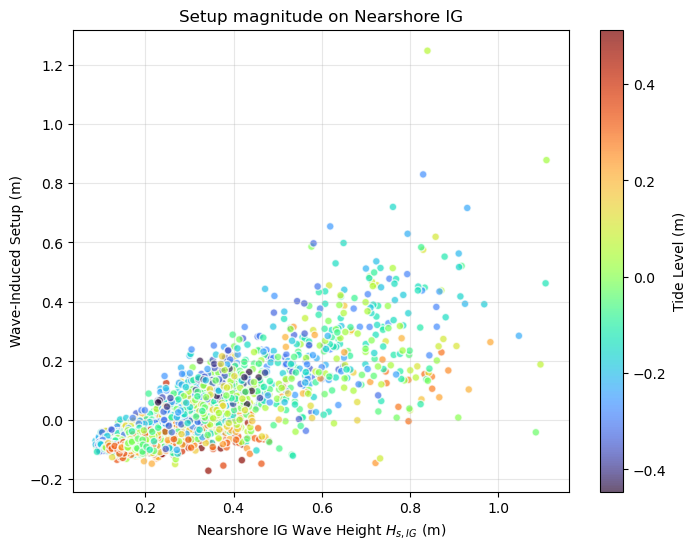

In [32]:
# 6. Create the "Story" Plot
plt.figure(figsize=(8, 6))

# Scatter plot: Setup vs H0, colored by Peak Period (Tp)
# (Assuming final_df has 'Tp' - if not, add it!)
sc = plt.scatter(merged_df['Hs_IG_Nearshore'], 
                 merged_df['n'], 
                 c=merged_df['h_tide'], 
                 cmap='turbo', 
                 alpha=0.7, 
                 s=30,
                 
                 edgecolors='w')

plt.colorbar(sc, label='Tide Level (m)')
plt.xlabel('Nearshore IG Wave Height $H_{s,IG}$ (m)')
plt.ylabel('Wave-Induced Setup (m)')
plt.title('Setup magnitude on Nearshore IG')
plt.grid(True, alpha=0.3)

# Add a 1:1 line for reference (optional, though IG is usually much smaller than H0)
# plt.plot([0, 3], [0, 3], 'k--', alpha=0.5) 

plt.show()

In [40]:
## save working data frames
binned_df.to_parquet('binned2H0.parquet')
merged_df.to_parquet('bulk_df.parquet')


In [39]:
final_df

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp
time,,,,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955,150.728218,0.017955,14.634210
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696,134.353266,0.019696,13.846214
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448,144.989335,0.018448,14.173290
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691,116.178469,0.019691,13.333391
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951,95.942475,0.019951,13.740518
...,...,...,...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608,230.658171,0.011608,12.676112
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486,250.038532,0.013486,13.333391
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754,210.542782,0.012754,12.949697


In [38]:
merged_df

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp,Hs_IG_Nearshore
time,,,,,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955,150.728218,0.017955,14.634210,0.196278
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696,134.353266,0.019696,13.846214,0.209341
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448,144.989335,0.018448,14.173290,0.210029
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691,116.178469,0.019691,13.333391,0.205247
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951,95.942475,0.019951,13.740518,0.168462
...,...,...,...,...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608,230.658171,0.011608,12.676112,0.256726
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486,250.038532,0.013486,13.333391,0.227943
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754,210.542782,0.012754,12.949697,0.248969
